In [0]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ckpt   input_Conv   NN_Conv.ipynb  Trigo_NN_FC.ipynb
input  input_trigo  NN_FC.ipynb


Create dataloaders

In [0]:
from torch.utils.data import Dataset
class csv2Dataset(Dataset):
  def __init__(self, csv_file):
    self.frame = pandas.read_csv(csv_file, header=None)
    self.mean = self.frame.mean()
    self.std = self.frame.std()
    self.frame = self.frame.fillna(0)
    self.frame = (self.frame - self.mean) / self.std

  def getMean(self):
    return self.mean

  def getStd(self):
    return self.std

  def __len__(self):
      return len(self.frame)

  def __getitem__(self, idx):
    x = self.frame.iloc[idx, 0:72]
    y = self.frame.iloc[idx, 72]
    sample = {'x': torch.tensor(x), 'y': torch.tensor(y)}
    return sample

In [0]:
import numpy as np
import pandas
import random
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

#random.seed(0)
#torch.manual_seed(0)
#np.random.seed(0)
#torch.cuda.manual_seed(0)
#torch.backends.cudnn.determenistic = True

path = '/content/drive/My Drive/Colab Notebooks/'

train_dataset = csv2Dataset(path + 'input/train.csv')
test_dataset = csv2Dataset(path + 'input/test.csv')
val_dataset =  csv2Dataset(path + 'input/validation.csv')


In [0]:
batch_size = 100
train_dataloader = torch.utils.data.DataLoader(
  train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
  drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
  val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,
  drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, 
  drop_last = True
)

In [0]:
print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))
print(len(test_dataloader), len(test_dataset))

138 13844
312 31295
203 20383


Create template of model

In [0]:
class FCNet(torch.nn.Module):
  def __init__(self, N_hidden, act_func, n_count):
    super(FCNet, self).__init__()
    self.fcs = []
    self.bns = []
    self.N_hidden = N_hidden
    self.act_func = act_func
    for i in range(self.N_hidden):
      if (i == 0):
        n_in = 72
      else:
        n_in = n_count
      if (i == self.N_hidden - 1):
        n_out = 1
      else:
        n_out = n_count
      fc = torch.nn.Linear(n_in, n_out)
      setattr(self, 'fc%i' % i, fc)
      self.fcs.append(fc)
      if (i < self.N_hidden - 1):
        bn = torch.nn.BatchNorm1d(n_out)
        setattr(self, 'bn%i' % i, bn)
        self.bns.append(bn)

  def forward(self, x):
    for i in range(self.N_hidden):
      residiual = x.clone()
      x = self.fcs[i](x)
      if (i < self.N_hidden - 1):
        x = self.act_func(x)
        x = self.bns[i](x)
      if (i >= 1 and i < self.N_hidden - 1):
        x += residiual
    return x

In [0]:
list_loss_val = []
list_loss_train = []

def train_model(name, model, loss, optimizer, scheduler, num_epochs):
  for epoch in range(num_epochs):
    if ((epoch + 1) % 10 == 0):
      torch.save(model.state_dict(), path + "ckpt/" + name + "/" + str(epoch) + ".ckpt")
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
    
    for phase in ['train', 'val']:
      tot_loss = 0.0
      if phase == 'train':
        dataloader = train_dataloader
        #scheduler.step()
        model.train()
      else:
        dataloader = val_dataloader
        model.eval()

      for idx, batch in enumerate(dataloader):
        args = batch['x'].to(device)
        val = batch['y'].to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          inference = model(args)
          loss_value = loss(inference, val.reshape(batch_size, 1))
          tot_loss += loss_value.item()
          
        if phase == 'train':
          loss_value.backward()
          optimizer.step()
      
      if phase =='train':
        list_loss_train.append(tot_loss / batch_size)
      else:
        list_loss_val.append(tot_loss / batch_size)
      print('{} Loss: {:.4f} '.format(phase, tot_loss / batch_size , flush=True))
  return model

Create custom model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

name = 'fc14l30n'
ct_layers = 14
act_func = torch.nn.ReLU()
n_count = 30
model = FCNet(ct_layers, act_func, n_count)
num_epochs = 100

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4, momentum = 0.95)

# Decay LR by a factor of 0.5 every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
print('model was created')

loss = torch.nn.MSELoss()
os.mkdir(path + "ckpt/" + name)

model was created


FileExistsError: ignored

In [0]:
train_model(name, model, loss, optimizer, scheduler, num_epochs)

Epoch 0/99:
train Loss: 0.7884 
val Loss: 0.5839 
Epoch 1/99:
train Loss: 0.2213 
val Loss: 0.3998 
Epoch 2/99:
train Loss: 0.1698 
val Loss: 0.3300 
Epoch 3/99:
train Loss: 0.1472 
val Loss: 0.2921 
Epoch 4/99:
train Loss: 0.1326 
val Loss: 0.2654 
Epoch 5/99:
train Loss: 0.1238 
val Loss: 0.2459 
Epoch 6/99:
train Loss: 0.1192 
val Loss: 0.2323 
Epoch 7/99:
train Loss: 0.1122 
val Loss: 0.2207 
Epoch 8/99:
train Loss: 0.1059 
val Loss: 0.2100 
Epoch 9/99:
train Loss: 0.0994 
val Loss: 0.2010 
Epoch 10/99:
train Loss: 0.0981 
val Loss: 0.1977 
Epoch 11/99:
train Loss: 0.0933 
val Loss: 0.1897 
Epoch 12/99:
train Loss: 0.0888 
val Loss: 0.1809 
Epoch 13/99:
train Loss: 0.0886 
val Loss: 0.1759 
Epoch 14/99:
train Loss: 0.0870 
val Loss: 0.1771 
Epoch 15/99:
train Loss: 0.0816 
val Loss: 0.1668 
Epoch 16/99:
train Loss: 0.0821 
val Loss: 0.1630 
Epoch 17/99:
train Loss: 0.0794 
val Loss: 0.1578 
Epoch 18/99:
train Loss: 0.0813 
val Loss: 0.1553 
Epoch 19/99:
train Loss: 0.0737 
val Loss

FCNet(
  (act_func): ReLU()
  (fc0): Linear(in_features=72, out_features=30, bias=True)
  (bn0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=30, out_features=30, bias=True)
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (bn2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (bn3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=30, out_features=30, bias=True)
  (bn4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=30, out_features=30, bias=True)
  (bn5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=30, out_features=30, bias=True)
  (bn6): BatchNorm

In [0]:
file = open(path + 'ckpt' + '/' + name + '/loss_val', 'w')
for val in list_loss_val:
  file.write(str(val) + '\n')
file.close()

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'w')
for val in list_loss_train:
  file.write(str(val) + '\n')
file.close()

Loss on test

In [0]:
import math

model.eval()
state_dict = torch.load(path + "ckpt/" + "fc14l30n/90" + ".ckpt") 
model.load_state_dict(state_dict)
target_list = torch.Tensor(len(test_dataloader), batch_size)
inference_list = torch.Tensor(len(test_dataloader), batch_size)

dataloader = test_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val * test_dataset.getStd()[72] + test_dataset.getMean()[72]
  inference_list[idx] = inference.reshape(batch_size) * train_dataset.getStd()[72] + train_dataset.getMean()[72]
  loss_value += loss(inference_list[idx], target_list[idx]).item()

loss_value /= len(test_dataloader)
loss_value = math.sqrt(loss_value)
print('Test Loss: {:f} '.format(loss_value, flush=True))

Test Loss: 32.731578 


Draw inference(target) Test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: numpy.arange
  """


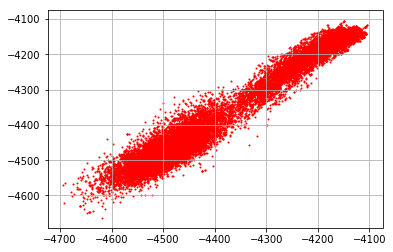

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

my_fig = plt.figure()
x_lin = mlab.frange(-4800.0, 100.0, -4200.0)
plt.plot(x_lin, x_lin)

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss on train 

In [0]:
target_list = torch.Tensor(len(train_dataloader), batch_size)
inference_list = torch.Tensor(len(train_dataloader), batch_size)

dataloader = train_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val * train_dataset.getStd()[72] + train_dataset.getMean()[72]
  inference_list[idx] = inference.reshape(batch_size) * train_dataset.getStd()[72] + train_dataset.getMean()[72]
  loss_value += loss(inference_list[idx], target_list[idx])

loss_value /= len(train_dataloader)
loss_value = math.sqrt(loss_value)
print('Train Loss: {:.4f} '.format(loss_value, flush=True))

Train Loss: 24.5713 


Draw inference(target) train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: numpy.arange
  


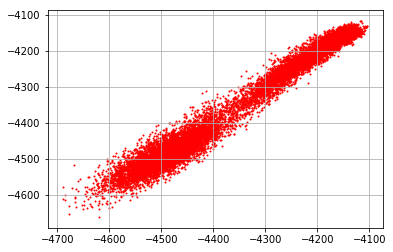

In [0]:
my_fig = plt.figure()
x_lin = mlab.frange(-4800.0, 100.0, -4200.0)
plt.plot(x_lin, x_lin)

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss(epochs) on train

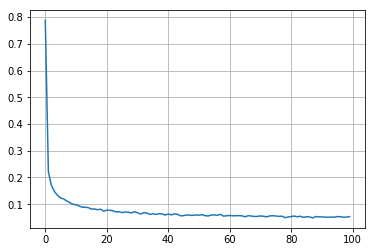

In [0]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()

Loss(epochs) on validation

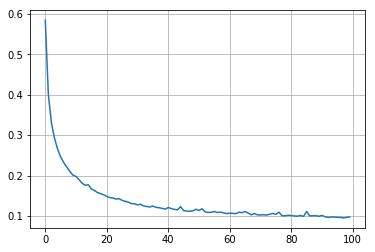

In [0]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_val', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()